In [1]:
import rasterio
from rasterio.transform import rowcol
from pyproj import Transformer

In [2]:
hennepin = rasterio.open("data/hennepin.tif")
green = rasterio.open("data/3.tif")


In [3]:
h_to_wgs84 = Transformer.from_crs(hennepin.crs, "EPSG:4326", always_xy=True)
h_from_wgs84 = Transformer.from_crs("EPSG:4326", hennepin.crs, always_xy=True)

g_to_wgs84 = Transformer.from_crs(green.crs, "EPSG:4326", always_xy=True)
g_from_wgs84 = Transformer.from_crs("EPSG:4326", green.crs, always_xy=True)

In [4]:
h_band = hennepin.read(1)
g_band = green.read(1)

In [5]:
# Replace all of the heat nodata values with 0

h_band[h_band > 1e5] = 0

In [6]:
import pandas as pd
y = pd.DataFrame(g_band)
y.describe()

0            1            2            3            4     \
count  5522.000000  5513.000000  5534.000000  5545.000000  5571.000000   
mean      0.243434     0.244327     0.242727     0.242944     0.243834   
std       0.102643     0.101606     0.102088     0.103279     0.102470   
min       0.003040     0.003040     0.003096     0.003040     0.003155   
25%       0.170892     0.171053     0.169651     0.164983     0.168317   
50%       0.261194     0.260726     0.258520     0.261194     0.262745   
75%       0.325671     0.325581     0.324532     0.325714     0.323308   
max       0.478873     0.500000     0.494382     0.479452     0.496855   

              5            6            7            8            9     ...  \
count  5562.000000  5576.000000  5567.000000  5518.000000  5503.000000  ...   
mean      0.245085     0.244825     0.244829     0.244906     0.241864  ...   
std       0.102143     0.103446     0.103883     0.103172     0.103693  ...   
min       0.002950     0.002801     0.003215     0.003195     0.003115  ...   
25%       0.170776     0.169654     0.170569     0.175274     0.168351  ...   
50%       0.263538     0.263538     0.263941     0.262951     0.261044  ...   
75%       0.323392     0.325843     0.326165     0.323636     0.322835  ...   
max       0.477387     0.484211     0.476190     0.464286     0.485380  ...   

              9957         9958         9959         9960         9961  \
count  5452.000000  5407.000000  5374.000000  5344.000000  5407.000000   
mean      0.244628     0.243315     0.243153     0.244935     0.245103   
std       0.122588     0.123155     0.123058     0.122279     0.122513   
min       0.003040     0.002967     0.003135     0.003077     0.002915   
25%       0.151316     0.146457     0.149254     0.154296     0.151515   
50%       0.261194     0.261993     0.259401     0.260785     0.260870   
75%       0.339074     0.340824     0.339286     0.339450     0.338645   
max       0.588235     0.579710     0.593750     0.583333     0.600000   

              9962         9963         9964         9965         9966  
count  5382.000000  5378.000000  5424.000000  5397.000000  5355.000000  
mean      0.246836     0.247616     0.245002     0.244754     0.246486  
std       0.122078     0.122486     0.123089     0.121858     0.121851  
min       0.002899     0.002755     0.002786     0.002899     0.003077  
25%       0.155773     0.158818     0.151744     0.151786     0.154800  
50%       0.262774     0.267176     0.266061     0.261993     0.264463  
75%       0.341085     0.340180     0.340909     0.340741     0.340996  
max       0.600000     0.590909     0.641379     0.574468     0.568182  

[8 rows x 9967 columns]

First we define the bounding box, which is the same bounding box of the green space band.

Now we write some code that gets a random acre inside the bounding box.

In [7]:
import numpy as np

ACRE_EDGE_METERS = 500
DEGREES_PER_METER = 8.983e-6

In [8]:
from rasterio.windows import Window

def generate_point():
    lat = np.random.uniform(
        green.bounds.bottom + ACRE_EDGE_METERS * DEGREES_PER_METER, 
        green.bounds.top
    )

    lon = np.random.uniform(
        green.bounds.left, 
        green.bounds.right - ACRE_EDGE_METERS * DEGREES_PER_METER
    )
    return lat, lon

def generate_window(region, from_wsg84, lon, lat):
    x, y = from_wsg84.transform(lon, lat)
    row_min, col_min = rowcol(region.transform, x, y)

    # Bottom right
    x, y = from_wsg84.transform(lon + ACRE_EDGE_METERS * DEGREES_PER_METER, lat - ACRE_EDGE_METERS * DEGREES_PER_METER)
    row_max, col_max = rowcol(region.transform, x, y)
    window = Window(col_off=col_min, row_off=row_min, width=col_max-col_min+1, height=row_max-row_min+1)

    return window

In [9]:
data = {
    "heat": [],
    "green": [],
    "lat": [],
    "lon": []
}

vals = 0

all_points = {
    'lat': [],
    'lon': []
}

il = 0

while vals < 1_000:
    il += 1
    # Generate random coordinates
    lat, lon = generate_point()
    all_points['lat'].append(lat)
    all_points['lon'].append(lon)

    # Get windows
    green_window = generate_window(green, g_from_wgs84, lon, lat)
    heat_window = generate_window(hennepin, h_from_wgs84, lon, lat)

    green_data = green.read(1, window=green_window)
    heat_data = hennepin.read(1, window=heat_window)

    if not (
        np.isfinite(heat_data.sum()) 
        and 
        np.isfinite(green_data.sum())
    ):
        print(f"Longitude: {lon} | Latitude: {lat}")
        if not np.isfinite(heat_data.sum()):
            print(f"Illegal heat value {il}: {heat_data.sum()}. Skipping...")
        else :
            print(f"Illegal green value {il}: {green_data.sum()}. Skipping...")
        continue
    vals += 1
    data["heat"].append(heat_data.sum())
    data["green"].append(green_data.sum())
    data["lat"].append(lat)
    data["lon"].append(lon)

Longitude: -93.07517447888809 | Latitude: 44.65193240625851
Illegal green value 1: nan. Skipping...
Longitude: -92.94896915517494 | Latitude: 45.11424377992971
Illegal heat value 2: inf. Skipping...
Longitude: -93.213973542855 | Latitude: 44.975487038750245
Illegal green value 3: nan. Skipping...
Longitude: -93.51169272670514 | Latitude: 44.63957248166916
Illegal green value 4: nan. Skipping...
Longitude: -93.26710011993625 | Latitude: 44.65171596900759
Illegal green value 5: nan. Skipping...
Longitude: -92.90628088934382 | Latitude: 44.650472890695426
Illegal green value 6: nan. Skipping...
Longitude: -93.36455043333005 | Latitude: 44.898103148247095
Illegal heat value 7: inf. Skipping...
Longitude: -92.98870225506941 | Latitude: 45.127474868086026
Illegal heat value 8: inf. Skipping...
Longitude: -93.41521554602961 | Latitude: 45.047134946721734
Illegal heat value 9: inf. Skipping...
Longitude: -93.20705191821334 | Latitude: 44.78906995295272
Illegal heat value 10: inf. Skipping...
L

/Users/propoop/Code/greenalysis/greenalysis/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Longitude: -93.61723856514686 | Latitude: 44.67705896239074
Illegal green value 1271: nan. Skipping...
Longitude: -93.07135549933605 | Latitude: 44.756594671613044
Illegal green value 1272: nan. Skipping...
Longitude: -92.8318274051393 | Latitude: 44.585909775197216
Illegal green value 1273: nan. Skipping...
Longitude: -93.33114557945102 | Latitude: 44.60991925615048
Illegal heat value 1274: inf. Skipping...
Longitude: -93.62584184068054 | Latitude: 44.81492436159181
Illegal green value 1275: nan. Skipping...
Longitude: -93.60580279358604 | Latitude: 44.891165153699646
Illegal heat value 1276: inf. Skipping...
Longitude: -93.17188339547941 | Latitude: 44.59858199874843
Illegal green value 1277: nan. Skipping...
Longitude: -93.69405740628025 | Latitude: 44.58342690152948
Illegal green value 1278: nan. Skipping...
Longitude: -92.98080124689176 | Latitude: 44.876516184905356
Illegal heat value 1279: inf. Skipping...
Longitude: -92.90173286094644 | Latitude: 45.062519187329556
Illegal gree

# TODO

Fix the missing values...

In [23]:
df = pd.DataFrame(data)

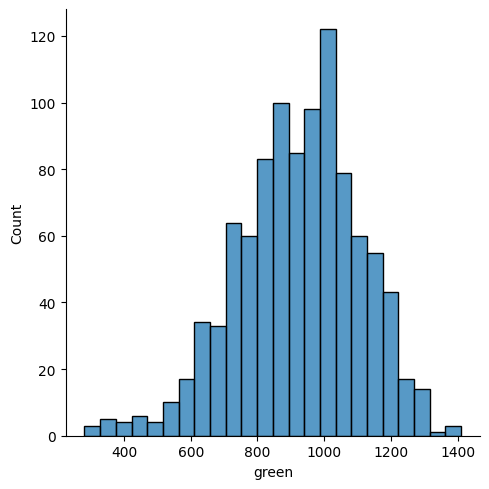

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

standardized = df

# standardized['heat'] = np.log(df['heat'])
sns.displot(data=df, x='green')

In [12]:
# max heat before replacing

df['heat'].max()

np.float64(1.79e+308)

In [13]:
# Fill in the nodata values with the mean heat

df['heat'].replace(1.79e+308, df[df['heat'] < 5000]['heat'].mean(), inplace=True)

/var/folders/nl/1zt_x2492zq3mm3dtgmv97k00000gn/T/ipykernel_32412/3640842145.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['heat'].replace(1.79e+308, df[df['heat'] < 5000]['heat'].mean(), inplace=True)


In [14]:
# Verify that the max is a finite value

df['heat'].max()

np.float64(177864.88272032136)

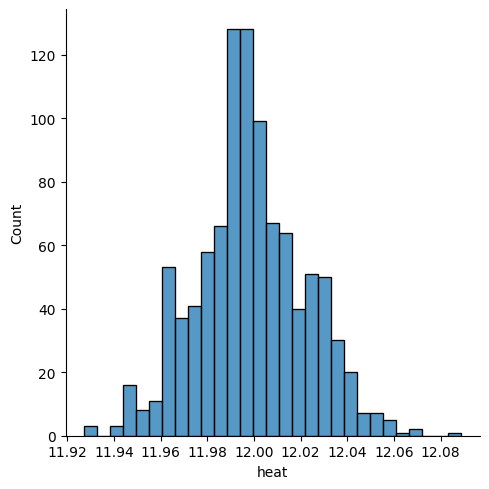

In [15]:
# Take the logarithm of all the heat values since they're huge
df['heat'] = np.log(df['heat'])

sns.displot(data=df, x='heat')

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convert data to arrays
X = np.array(df["green"]).reshape(-1, 1)
y = np.array(df["heat"])

# Remove bad values
mask = np.isfinite(X).flatten() & np.isfinite(y)
X = X[mask]
y = y[mask]

Since the $p$-value is below 0.05 and the coefficient for x1 is negative, it follows that there is a negative correlation between the amount of green space and heat. The goal is to now minimize the MSE by introducing various regresion models of various complexities.

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures

for deg in range(10):
    kf = KFold(n_splits=10, shuffle=True)
    res = 0
    for (train_index, test_index) in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Fit OLS model
        poly = PolynomialFeatures(1)
        X_poly = poly.fit_transform(X_train)
        X_polyy = poly.fit_transform(X_test)
        model = LinearRegression()

        results = model.fit(X_poly, y_train)

        y_pred = results.predict(X_polyy)
        res += mean_squared_error(y_test, y_pred)
    print(f"{deg} | Average MSE: {res / 10}")

0 | Average MSE: 0.00044379550064605844
1 | Average MSE: 0.00044251703694350735
2 | Average MSE: 0.0004425368427216381
3 | Average MSE: 0.0004433563119949584
4 | Average MSE: 0.00044376072257356
5 | Average MSE: 0.0004425191460153431
6 | Average MSE: 0.0004429281543192008
7 | Average MSE: 0.00044219736888329497
8 | Average MSE: 0.0004449650955088961
9 | Average MSE: 0.00044293657659876684


In [18]:
i = 49
y_pred[i], y_test[i]

(np.float32(11.998401), np.float64(11.996787700495068))

In [19]:
cluster1 = df[df['heat'] > 4000]
cluster2 = df[(df['heat'] >= 3300) & (df['heat'] <= 4000)]
cluster3 = df[df['heat'] < 3300]

In [20]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Example: assume your df already exists
# # Assign cluster labels
# df['cluster'] = pd.cut(df['heat'],
#                        bins=[-float('inf'), 11.97, 12.03, float('inf')],
#                        labels=['cluster3', 'cluster2', 'cluster1'])

# # Scatter plot of lat vs lon colored by cluster
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=df, x='lon', y='lat', hue='cluster', palette='Set1', alpha=0.7)
# plt.title("Scatter plot of Lat vs Lon by Heat Cluster")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.legend(title='Cluster')
# plt.show()

<Axes: xlabel='lon', ylabel='lat'>

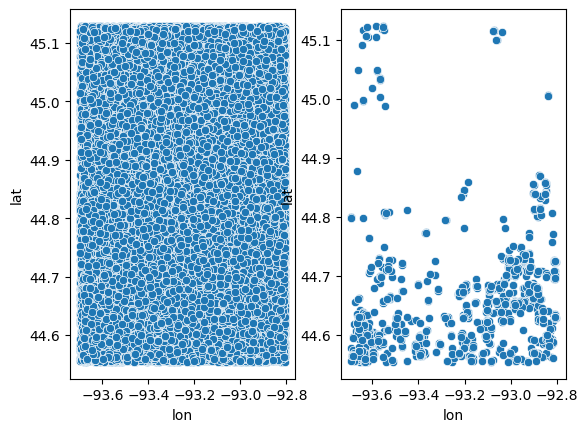

In [21]:
x = pd.DataFrame(all_points)

fig, ax = plt.subplots(1, 2)

sns.scatterplot(x, x='lon', y='lat', ax=ax[0])
sns.scatterplot(data, x='lon', y='lat', ax=ax[1])

In [22]:
x.describe()

lat           lon
count  65087.000000  65087.000000
mean      44.842114    -93.250702
std        0.165527      0.257040
min       44.554112    -93.695864
25%       44.698634    -93.473275
50%       44.843005    -93.251026
75%       44.985321    -93.027335
max       45.129111    -92.805053